In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
plt.style.use('ggplot')
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


In [63]:
import time
start = time.time()

In [64]:
fake_df = pd.read_csv("News _dataset/Fake.csv")
real_df = pd.read_csv("News _dataset/True.csv")

In [65]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [66]:
fake_df = fake_df[["title", "text"]]
real_df = real_df[["title", "text"]]

In [67]:
fake_df["class"] = 0
real_df["class"] = 1

In [68]:
df = pd.concat([fake_df, real_df], ignore_index = True, sort = False)

In [69]:
df.head()

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


In [70]:
df.shape

(44898, 3)

In [71]:
df["title_text"] = df["title"] + ' ' + df["text"]
df.drop(["title", "text"], axis = 1, inplace = True)

In [72]:
X = df["title_text"]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [73]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [74]:
vocab_size = 10000
embedding_dim = 64
max_length = 256
trunc_type = 'post'
padding_type = "post"
oov_tok = '<00V>'


In [75]:
# tokenizer = Tokenizer(num_words = max_vocab)
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [76]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding = padding_type, truncating = trunc_type, maxlen = max_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding = padding_type, truncating = trunc_type, maxlen = max_length)

In [80]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(embedding_dim, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [87]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.1, batch_size = 30, shuffle = True, callbacks = [early_stop])

2022-03-14 00:06:33.097773: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
1078/1078 [==============================] - 130s 118ms/step - loss: 0.1738 - accuracy: 0.9136 - val_loss: 0.0078 - val_accuracy: 0.9989
Epoch 2/10
1078/1078 [==============================] - 130s 120ms/step - loss: 0.0083 - accuracy: 0.9990 - val_loss: 0.0029 - val_accuracy: 0.9992
Epoch 3/10
1078/1078 [==============================] - 128s 119ms/step - loss: 0.0052 - accuracy: 0.9992 - val_loss: 0.0011 - val_accuracy: 0.9994
Epoch 4/10
1078/1078 [==============================] - 131s 121ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 4.4865e-04 - val_accuracy: 1.0000
Epoch 5/10
1078/1078 [==============================] - 128s 119ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 0.0038 - val_accuracy: 0.9989
Epoch 6/10
1078/1078 [==============================] - 129s 119ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9994


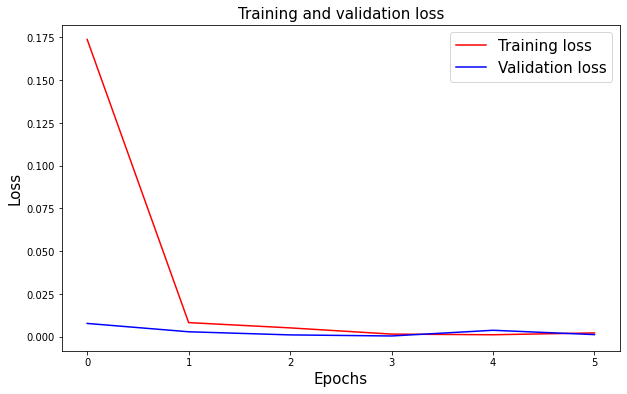

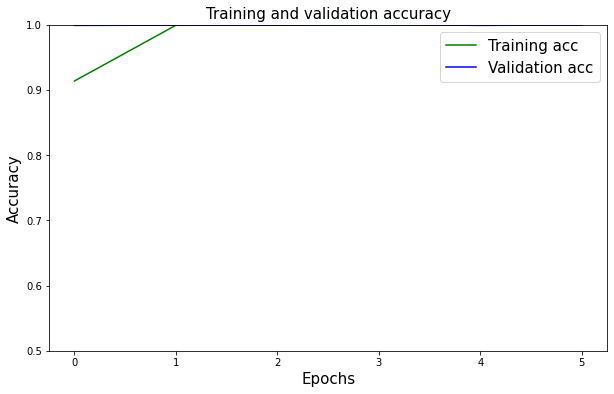

In [93]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize = (10,6))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss', size = 15)
plt.xlabel('Epochs', size = 15)
plt.ylabel('Loss', size = 15)
plt.legend(prop = {'size': 15})
plt.show()

plt.figure(figsize = (10, 6))
plt.plot(epochs, acc, 'g', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy', size = 15)
plt.xlabel('Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.legend(prop = {'size': 15})
plt.ylim((0.5,1))
plt.show()


In [94]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 8s 27ms/step - loss: 0.0045 - accuracy: 0.9991


[0.0045282780192792416, 0.999109148979187]

In [95]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [98]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9991091314031181
Precision on testing set: 0.9990625732364659
Recall on testing set: 0.9990625732364659


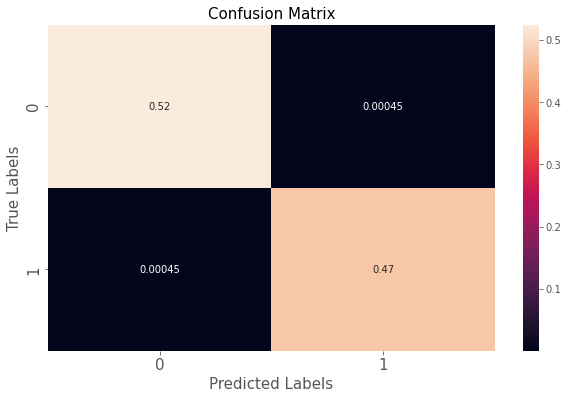

In [101]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(10, 6))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=15)
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15);

In [102]:
end = time.time()
print(end - start)

3259.045956850052
